In [72]:
import matplotlib
matplotlib.use('GTKagg')
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np
import json
import string
import dataCoverage
import sys
import datetime
from ipywidgets import Dropdown # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.display import clear_output

sys.path.append('../')
import senseapi

# default sourcename
sourceName = 'sense-library'
globalStartTime = None
globalEndTime = None
# default sensor names
sensorNames = ["noise", "accelerometer", "battery", "light", "position", "proximity", "sleep", "sleep_estimate", "time_active", "time_zone", "sense_log", "mental_resilience", "screen", "call", "app_info"]

# Get user credentials
try:
    f = open('credentials.txt', 'r')
except:
    print 'missing credentials.txt with username,password and application_key json'
creds = json.load(f)
f.close()

try:
    username = creds['username']
    password = creds['password']
    appKey = creds['application_key']
except:
    print 'session_id authentication not available!'
    username = ''
    password = ''
    appKey = ''

# Set SensorApi settings
api = senseapi.SenseAPI()
api.setVerbosity(False)
api.setServer('dev')
api.setAppKey(appKey)
password_md5 = senseapi.MD5Hash(password)

# Login
if not api.AuthenticateSessionId(username, password_md5):
    print api.getError()
    exit()

# Set the data coverage settings
dataCoverage = dataCoverage.DataCoverage()
dataCoverage.setSimpleCoverage(False) # we use the complex coverage comparing individual points

# Get all the data for a sensor
def getSensorData(sensorName, getParameters):
    sensorData = []
    lastTime = 0
    while True:
        # get data multiple times since there is a limit of 1000 points per call
        if api.SensorDataGet(sourceName, sensorName, getParameters):
            response = json.loads(api.getResponse())
            dataArray = response['data']
            # if there is no data then break, or if the last item is the same af previous round
            if len(dataArray) == 0 or lastTime == dataArray[len(dataArray)-1]["time"]:
                break
                
            # if this is the fist time then copy the whole response
            if len(sensorData) == 0:
                sensorData = dataArray
            # else don't copy the first item since, it's inclusive from the previous call
            else:
                sensorData += dataArray[1:]
                
            # we got less then the limit so we can stop now
            if len(dataArray) < 1000:
                break
                
            # get the time of the last item in the list
            lastTime = dataArray[len(dataArray)-1]["time"]
            # use the lastTime to select a new start period and get max 1000 points again
            getParameters['start_time'] = lastTime
        else:
            break
    return sensorData

def getSensorDataFrame(sensorName, start_time = None, end_time = None):
    """
        Returns the data coverage for a specific sensor and a predefined sourceName
        @param sensorName (string) The sensor name to get the data for and compute the coverage for
        @param interval (int) The interval used for this sensor
        @return (float) The coverage percentage, a value between 0 and 1
         
    """
    
    getParameters = {"sort":"ASC", "limit":1000}
    if start_time != None:
        getParameters["start_time"] = start_time
    elif globalStartTime != None:
        getParameters["start_time"] = globalStartTime
    if end_time != None:
        getParameters["end_time"] = end_time
    elif globalEndTime != None:
        getParameters["end_time"] = globalEndTime
    
    # get all the sensor data
    sensorData = getSensorData(sensorName, getParameters)
    if len(sensorData) == 0:
        return pd.DataFrame()
    sd = pd.DataFrame(sensorData)
    sd.index = pd.to_datetime(sd['time'],unit='ms')
    del sd['time']
    return sd

# Print the log
def printLog(logType = None, start_time = None, end_time = None):
    """
        Prints the log for a specific logtype
    """
    sense_log = getSensorDataFrame("sense_log", start_time, end_time)
    for i in range(0,sense_log.size):
        value = sense_log.value[i]
        time = sense_log.index[i]
        if logType == None or value["type"] == logType:
            print "{} {}\n{} : {}".format(time, value['type'], value['tag'], value['text'])

# Print the data coverage
def printCoverage(sensorName, interval, start_time = None, end_time = None):
    """
        Returns the data coverage for a specific sensor and a predefined sourceName
        @param sensorName (string) The sensor name to get the data for and compute the coverage for
        @param interval (int) The interval used for this sensor
        @return (float) The coverage percentage, a value between 0 and 1
         
    """
    getParameters = {"sort":"ASC", "limit":1000}
    if start_time != None:
        getParameters["start_time"] = start_time
    elif globalStartTime != None:
        getParameters["start_time"] = globalStartTime
    if end_time != None:
        getParameters["end_time"] = end_time
    elif globalEndTime != None:
        getParameters["end_time"] = globalEndTime
    
    coverage = 0
    avgInterval = 0
    
    # get all the sensor data
    sensorData = getSensorData(sensorName, getParameters)
    coverage, avgInterval = dataCoverage.coverage(sensorData, interval, start_time, end_time)
    print "{:20} coverage: {:6}%   interval: {:<6} min".format(sensorName, round(coverage*100.0,2), round(avgInterval/60000.0, 2))

def plotCoverage(sensorName, interval, savePlot = False, showPlot = True, start_time = None, end_time = None):
    """
        Returns the data coverage for a specific sensor and a predefined sourceName
        @param sensorName (string) The sensor name to get the data for and compute the coverage for
        @param interval (int) The interval used for this sensor
        @return (float) The coverage percentage, a value between 0 and 1
         
    """
    sd = getSensorDataFrame(sensorName, start_time, end_time)
    if sd.size == 0:
        return
    sd = sd['value']
    sd = sd.resample("60 min", how='count').fillna(0)
    baseline = 60.0/(interval/(1000*60))
    plt.figure(figsize=(20,10))
    plt.plot(sd.index, (sd.values/baseline)*100.0)    
    plt.title("Coverage % per hour for sensor: "+sensorName)
    plt.ylim([-10,110])
    if showPlot:
        plt.show()
    if savePlot:
        savefig("{}-{}_{}.png".format(start_time, end_time, sensorName))

def dictToColumn(data):
    for key in data['value'][0]:
        data[key] = data['value'].apply( lambda t : t[key])
    del data['value']
    return data
    

/home/ted/Pworkspace/commonsense-python-lib/venv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [75]:
# Coverage Settings
# Sample rates
sampling3Minutes = 3 * 60 * 1000
sampling5Minutes = 5 * 60 * 1000
defaultSampleRate = sampling3Minutes

# start time
#globalStartTime = int(datetime.datetime(2015,12,25,22,0).strftime('%s'))*1000
#globalEndTime = int(datetime.datetime(2015,12,26,12,0).strftime('%s'))*1000
globalStartTime = int(datetime.datetime(2016,1,7,22,0).strftime('%s'))*1000
globalEndTime = int(datetime.datetime(2016,1,8,9,0).strftime('%s'))*1000
# print "start epoch: {}".format(globalStartTime)
# print "end epoch: {}".format(globalEndTime)
#globalStartTime = None
#globalEndTime = None


In [3]:
# Print total coverage
printCoverage("noise", defaultSampleRate)
printCoverage("accelerometer", defaultSampleRate)
printCoverage("battery", defaultSampleRate)
printCoverage("light", defaultSampleRate)
printCoverage("position", defaultSampleRate)
printCoverage("proximity", defaultSampleRate)
printCoverage("sleep", sampling5Minutes)
printCoverage("sleep_estimate", defaultSampleRate)
printCoverage("time_active", defaultSampleRate)

# extra event based sensors
print "\n#Event based sensors"
printCoverage("time_zone", defaultSampleRate)
printCoverage("sense_log", defaultSampleRate)
printCoverage("mental_resilience", defaultSampleRate)
printCoverage("screen", defaultSampleRate)
printCoverage("call", defaultSampleRate)
printCoverage("app_info", defaultSampleRate)  

noise                coverage:  58.99%   interval: 4.89   min
accelerometer        coverage:  62.56%   interval: 3.62   min
battery              coverage:  91.32%   interval: 3.27   min
light                coverage:  75.45%   interval: 3.96   min
position             coverage:  57.08%   interval: 5.17   min
proximity            coverage:  62.56%   interval: 4.68   min
sleep                coverage:  89.39%   interval: 5.55   min
sleep_estimate       coverage:    0.0%   interval: 0.0    min
time_active          coverage:  63.01%   interval: 4.59   min

#Event based sensors
time_zone            coverage:    0.0%   interval: 0.0    min
sense_log            coverage:  61.82%   interval: 2.46   min
mental_resilience    coverage:    0.0%   interval: 0.0    min
screen               coverage:   10.0%   interval: 13.41  min
call                 coverage:  100.0%   interval: 0.0    min
app_info             coverage:    0.0%   interval: 0.0    min


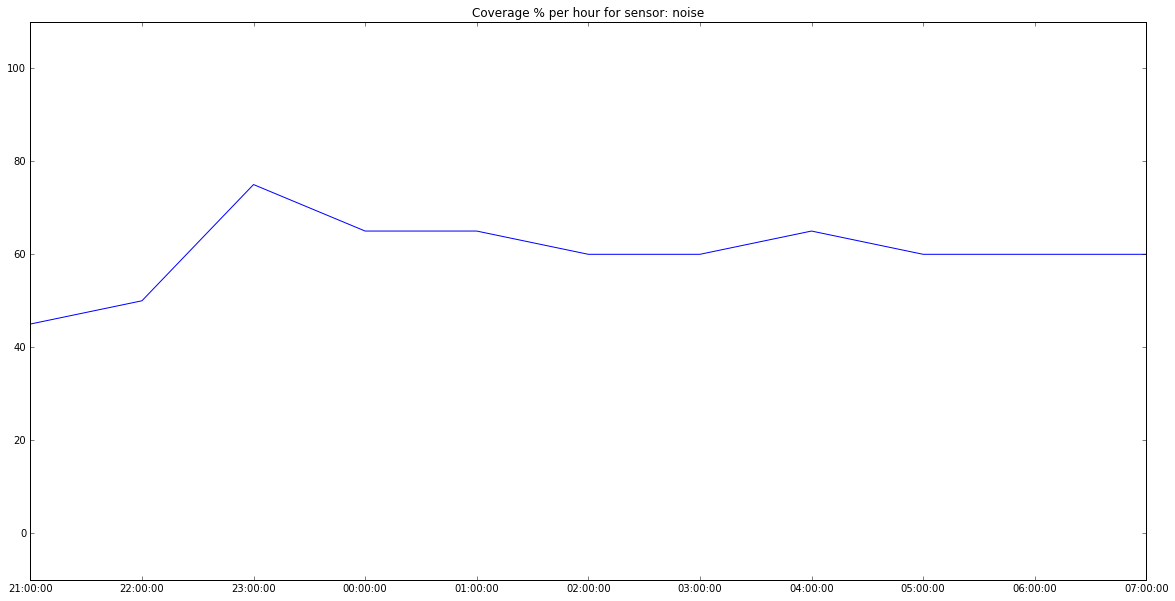

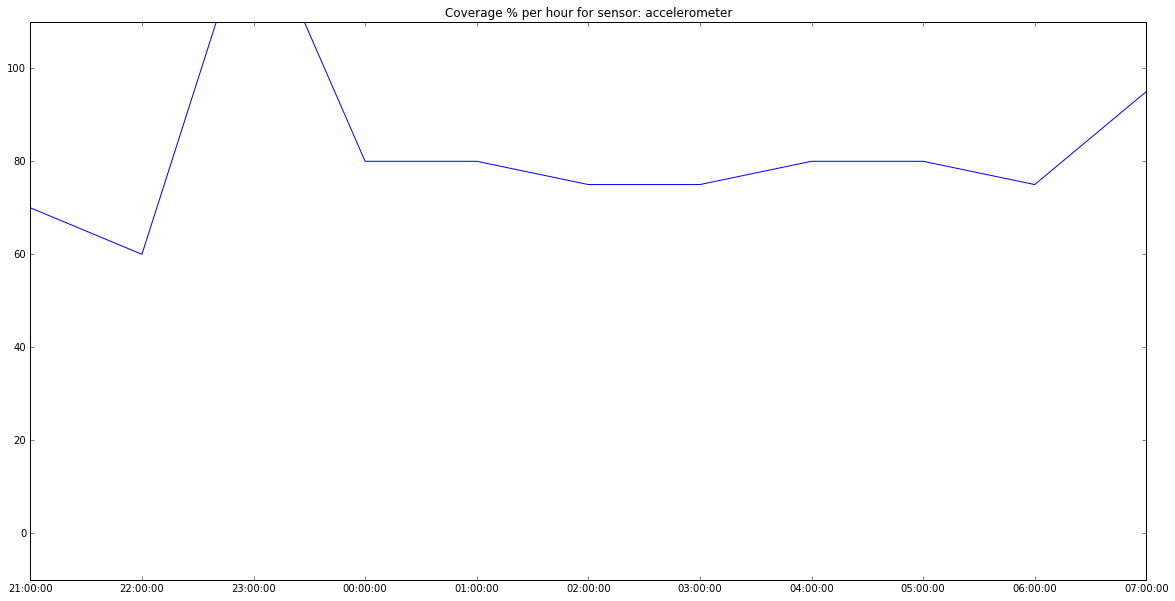

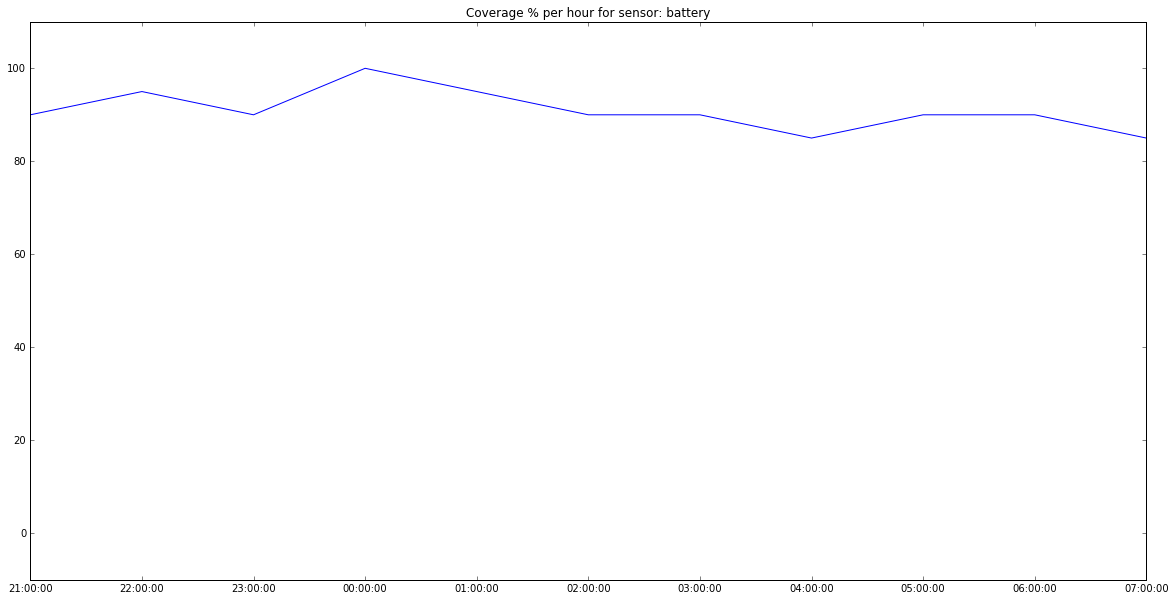

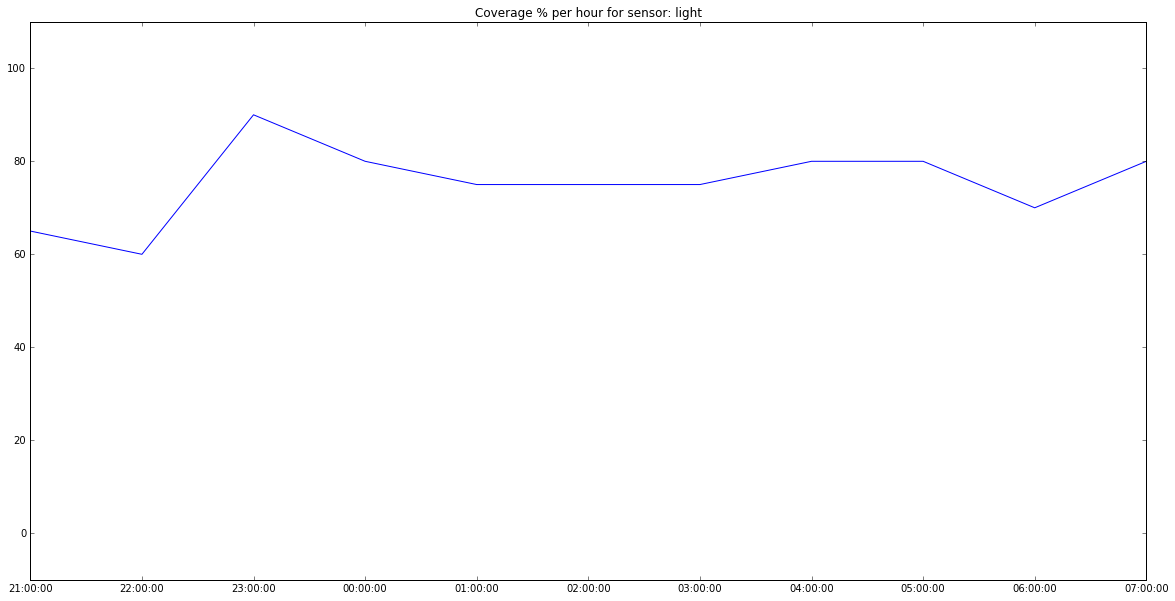

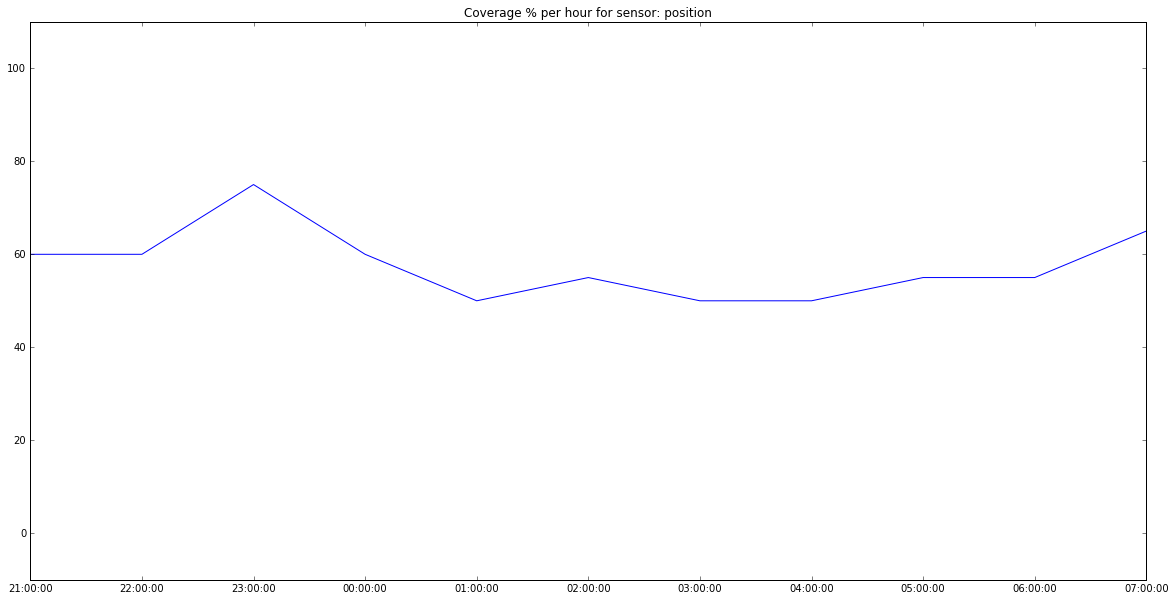

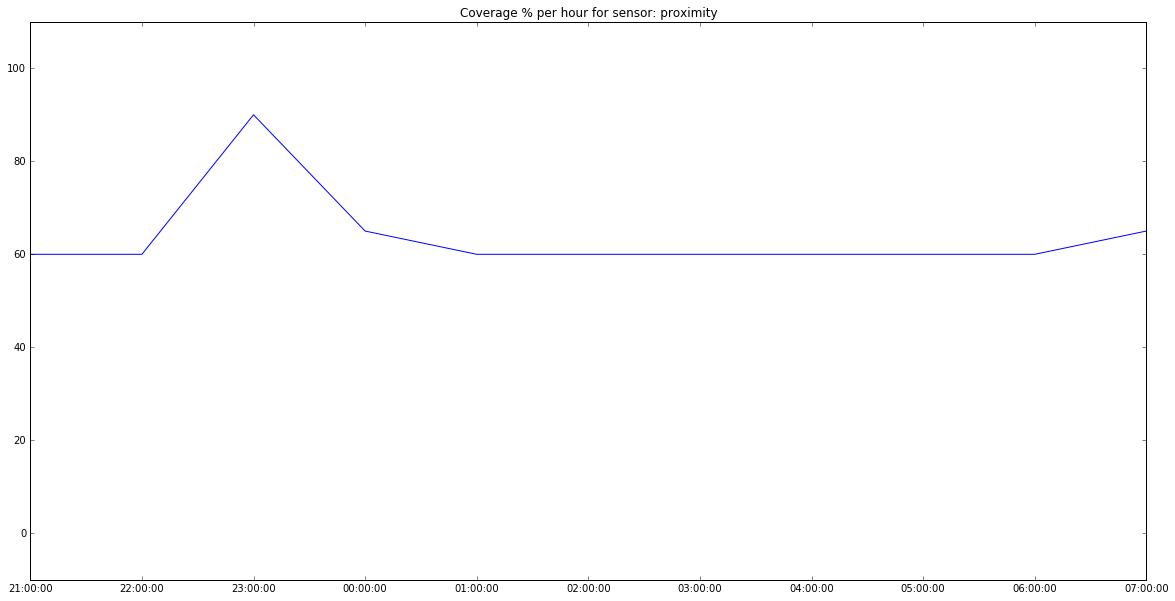

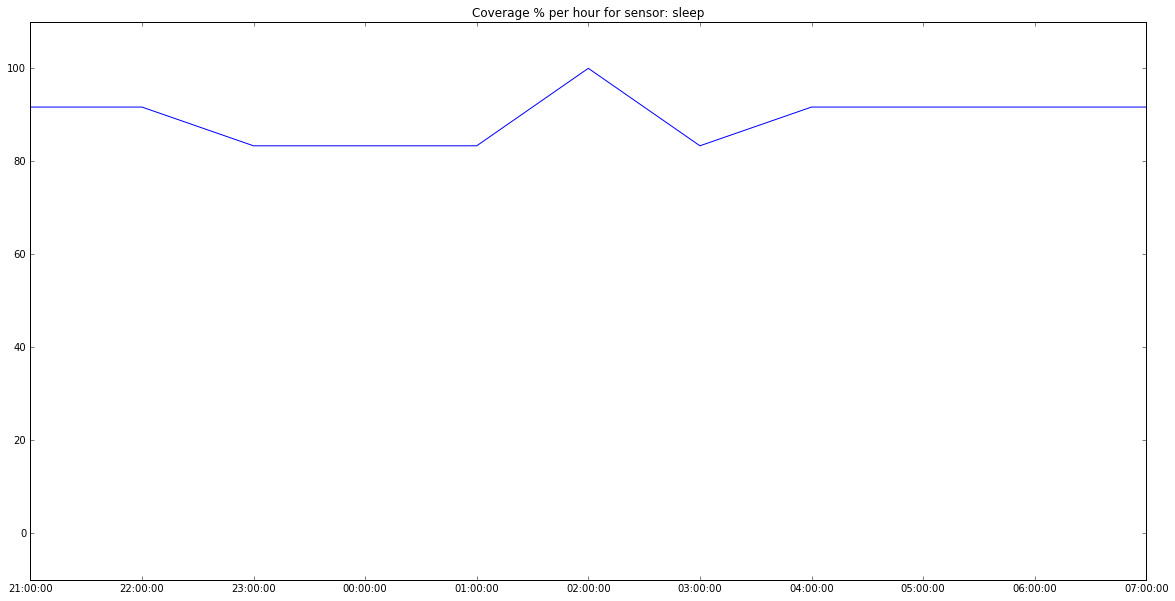

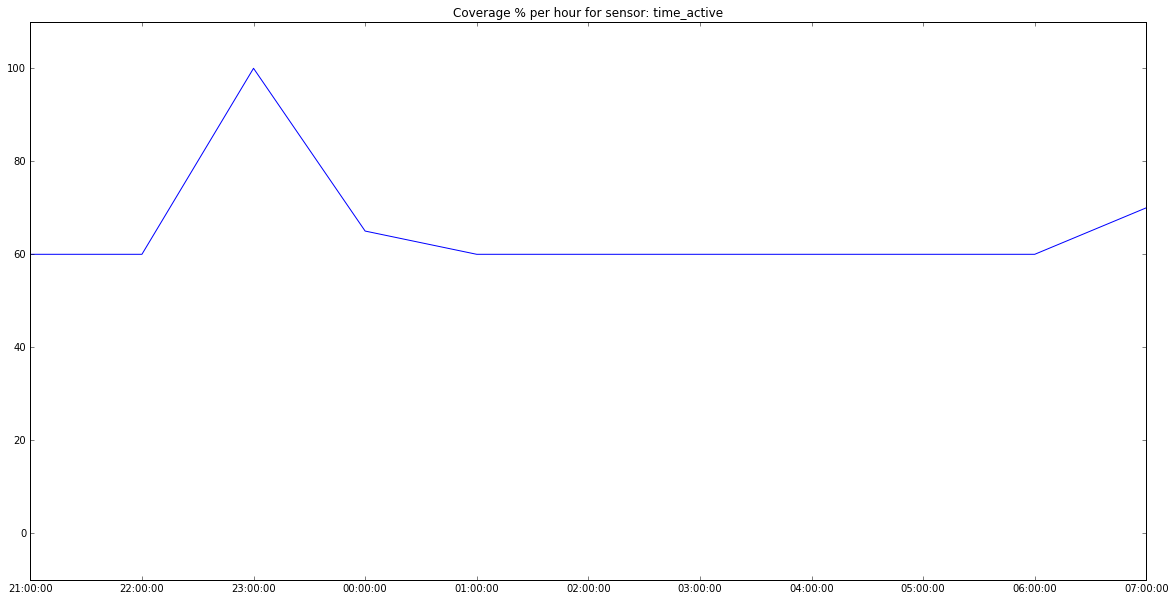

In [4]:
# plot coverage percentage
plotCoverage("noise", defaultSampleRate)
plotCoverage("accelerometer", defaultSampleRate)
plotCoverage("battery", defaultSampleRate)
plotCoverage("light", defaultSampleRate)
plotCoverage("position", defaultSampleRate)
plotCoverage("proximity", defaultSampleRate)
plotCoverage("sleep", sampling5Minutes)
plotCoverage("sleep_estimate", defaultSampleRate)
plotCoverage("time_active", defaultSampleRate)

In [7]:
printLog("ERROR")

2016-01-06 21:02:01.294000 ERROR
DSEDataConsumer : onNewData sensor:sleep_estimate: nl.sense_os.util.json.ValidationException: Invalid type for property 'history_based'. boolean expected.
	at nl.sense_os.util.json.JSONSchemaValidator.createInvalidTypeError(JSONSchemaValidator.java:156)
	at nl.sense_os.util.json.JSONSchemaValidator.validateType(JSONSchemaValidator.java:131)
	at nl.sense_os.util.json.JSONSchemaValidator.validate(JSONSchemaValidator.java:102)
	at nl.sense_os.util.json.JSONSchemaValidator.validateProperties(JSONSchemaValidator.java:162)
	at nl.sense_os.util.json.JSONSchemaValidator.validate(JSONSchemaValidator.java:116)
	at nl.sense_os.datastorageengine.Sensor.insertOrUpdateDataPoint(Sensor.java:150)
	at nl.sense_os.datastorageengine.Sensor.insertOrUpdateDataPoint(Sensor.java:112)
	at nl.sense_os.service.storage.DSEDataConsumer.onNewData(DSEDataConsumer.java:96)
	at nl.sense_os.service.subscription.BaseDataProducer.sendToSubscribers(BaseDataProducer.java:125)
	at nl.sense_

position             coverage:  57.08%   interval: 5.17   min


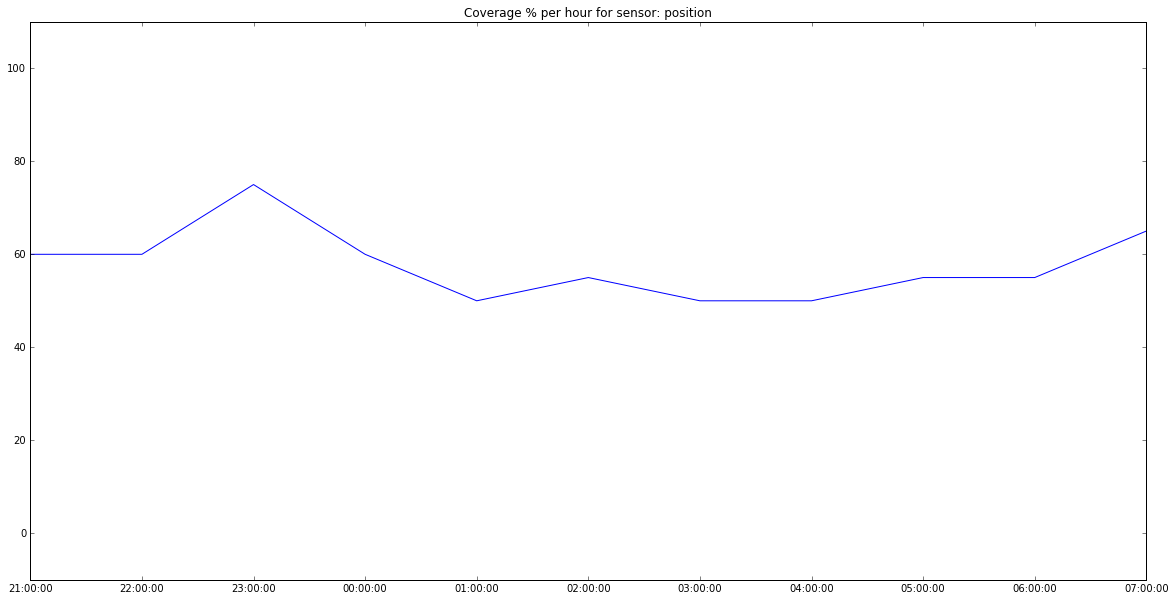

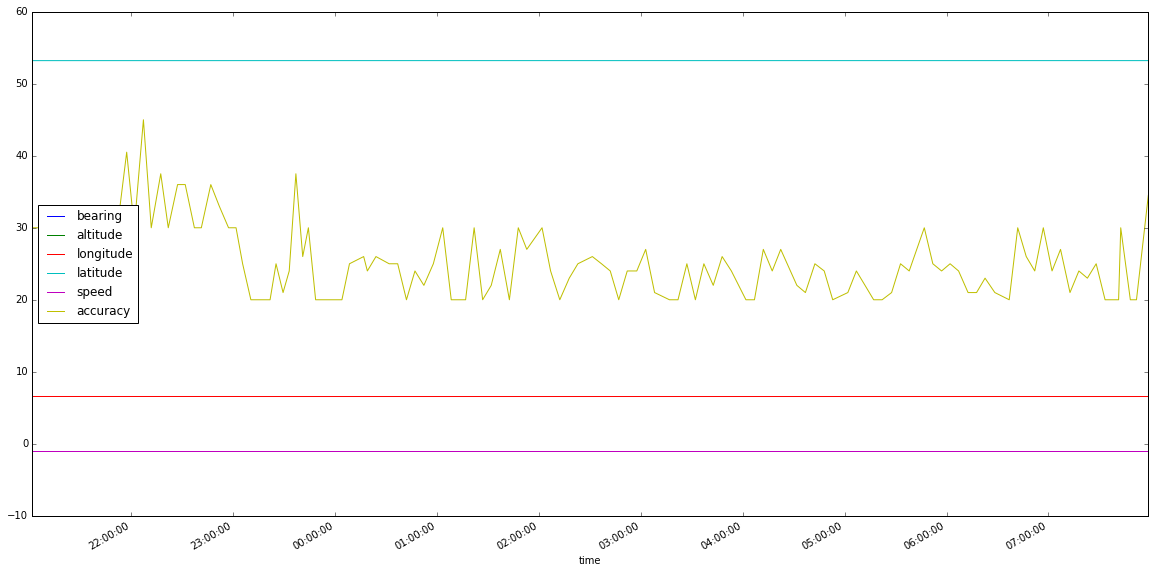

In [78]:
# plot sensor data
def on_sensor_select_change(name, value):
    clear_output()
    printCoverage(value, defaultSampleRate)
    plotCoverage(value, defaultSampleRate)
    data = getSensorDataFrame(value)
    if data.size == 0:
        print "not data"
        return

    if value == "sleep" or value == "sleep_estimate":
        data['value'] = data['value'].apply( lambda t : t['sleepTime'])
        for x in range(0, data.size):
            print data.index[x], data.values[x][0]
    
    # transform the 1 layer dict into a column 
    if isinstance(data.value[0], dict):
        data = dictToColumn(data)
    try:
        data.plot(figsize=(20,10))
    except:
        print data
        
sensorSelectWidget = Dropdown(description="Select a sensor",  options=[""]+sensorNames)
display(sensorSelectWidget)
sensorSelectWidget.on_trait_change(on_sensor_select_change, 'value')